In [109]:
import yfinance as yf
start_date = "2023-01-01"
data = yf.download("2330.TW", start=start_date, end=None, interval="1d")
data.columns = ['_'.join(col).strip() for col in data.columns.to_flat_index()]
data.head

C:\Users\user\AppData\Local\Temp\ipykernel_27804\3932857846.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("2330.TW", start=start_date, end=None, interval="1d")
[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of             Close_2330.TW  High_2330.TW  Low_2330.TW  Open_2330.TW  \
Date                                                                 
2023-01-03     432.406616    432.883886   422.861216    425.724836   
2023-01-04     429.065735    434.315705   428.111195    429.065735   
2023-01-05     437.656616    438.611156   434.315726    438.133886   
2023-01-06     437.656616    438.611156   434.315726    434.315726   
2023-01-09     459.133667    459.133667   446.247379    446.724649   
...                   ...           ...          ...           ...   
2025-09-08    1180.000000   1195.000000  1180.000000   1195.000000   
2025-09-09    1200.000000   1200.000000  1190.000000   1195.000000   
2025-09-10    1225.000000   1230.000000  1215.000000   1220.000000   
2025-09-11    1240.000000   1260.000000  1235.000000   1255.000000   
2025-09-12    1255.000000   1255.000000  1250.000000   1255.000000   

            Volume_2330.TW  
Date                        
2

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.plot import plot_prediction_intervals, set_dark_theme

orig_dates = data.index.copy()
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col!=series_col] + ['is_weekend']
data = data.asfreq("D").ffill()
data = data.sort_index()
data.loc[~data.index.isin(orig_dates), "Volume_2330.TW"] = 0
data['is_weekend'] = data.index.weekday >= 5

In [111]:
steps = 300
data_train = data[:-steps]
data_test  = data[-steps:]
# set_dark_theme()
# fig, ax = plt.subplots(figsize=(6, 3))
# data_train[series_col].plot(ax=ax, label='train')
# data_test[series_col].plot(ax=ax, label='test')
# ax.legend()

In [112]:
from sklearn.linear_model import LinearRegression
forecaster = ForecasterRecursive(
                 regressor       = LinearRegression(),
                 lags            = 15,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=10),
                 transformer_y   = None, 
             )

forecaster.fit(y=data_train[series_col], exog=data_train[exog_cols], store_in_sample_residuals=True)
forecaster

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location :                                                                           │
│ c:\Users\user\miniconda3\envs\lomba\Lib\site-packages\skforecast\utils\utils.py:641  │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Series name: Close_2330.TW 
Exogenous included: True 
Exogenous names: 
    High_2330.TW, Low_2330.TW, Open_2330.TW, Volume_2330.TW, is_weekend 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2023-01-03 00:00:00'), Timestamp('2024-11-16 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-09-12 10:29:51 
Last fit date: 2025-09-12 10:29:51 
Skforecast version: 0.17.0 
Python version: 3.12.11 
Forecaster id: None

In [113]:
predictions = forecaster.predict(steps=steps, exog=data_test[exog_cols])
predictions.head(3)

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location :                                                                           │
│ c:\Users\user\miniconda3\envs\lomba\Lib\site-packages\skforecast\utils\utils.py:641  │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

2024-11-17    1023.928720
2024-11-18    1013.258831
2024-11-19    1023.991610
Freq: D, Name: pred, dtype: float64

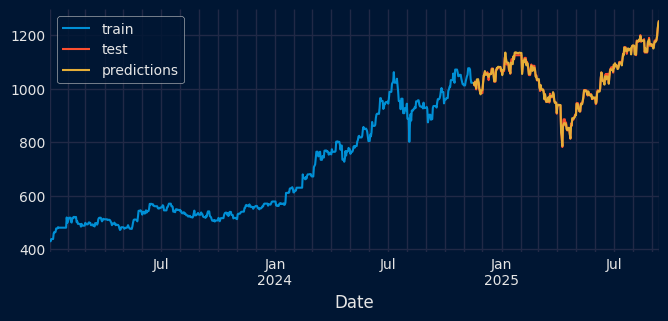

In [114]:
fig, ax = plt.subplots(figsize=(7, 3))
data_train[series_col].plot(ax=ax, label='train')
data_test[series_col].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [115]:
from sklearn.metrics import root_mean_squared_error
y_true = data_test[series_col].values
y_pred = predictions.values
error = root_mean_squared_error(y_true, y_pred)
print(error)

5.933721189022128
